In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.datasets import fetch_openml
import os.path as osp
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier as lgb

# Problem 0
As we have covered in class, we are training a logistic regression model to predict if someone will click on an advertisement. Consider the logistic regression model with 3 features and weights w = [1, −30, 3]. For the dataset with features x1=[20,0,0], y1=1 and x2=[23,1,1], y2=0

In [16]:
# Bullet 1, Compute the probabilities that the logistic regression assigns to these two customers clicking on the advertisement (i.e. P (y = 1))
w = np.array([1,-30,3])
x1, y1 = np.array([20,0,0]).T, np.array([1]).T
x2, y2 = np.array([23,1,1]).T, np.array([0]).T

s1 = np.dot(w,x1)
s2 = np.dot(w,x2)

def sigmoid(z):
    denom = 1 + np.exp(-z)
    return 1/denom

z1 = sigmoid(s1)
z2 = sigmoid(s2)

print('Probabilities that customers click on the advertisement: y1 -> ', z1, '; y2 -> ', 1-z2, sep="")


Probabilities that customers click on the advertisement: y1 -> 0.9999999979388463; y2 -> 0.9820137900379085


In [2]:
# Bullet 2, Compute the cross entropy loss of this logistic regression.

def cross_entropy(p, q):
    return -(p*np.log2(q) + (1-p)*np.log2((1-q)))

print('Cross Entropy loss: ', cross_entropy(z1, z2))

Cross Entropy loss:  5.796964962660905


Impurity of the root: 49.76%
Our split: 21.50
Impurity for left leaf (0.00%) and the right leaf (0.00%)


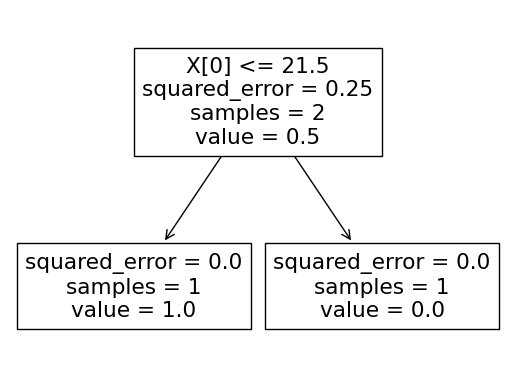

In [3]:
# Bullet 3, Design a decision stump (a decision tree of depth 1) that splits on the first feature. What is the Gini impurity of the root? 
# What is the Gini impurity after the best split that you find?
def gini_impurity(proba : list):
    pr_sq = [np.square(x) for x in proba]
    impurity = 1 - sum(pr_sq)
    return impurity

root = DecisionTreeRegressor(criterion="squared_error", splitter="best", max_depth=1, ccp_alpha=0)

X = np.vstack((x1[0], x2[0]))
Y = np.vstack((y1, y2))

root.fit(X, Y)
y_pred = root.predict(X)
plot_tree(root, max_depth=1)

# Calculations being done by hand

root_bucket = x1[0] + x2[0]
proba = [x1[0]/root_bucket, x2[0]/root_bucket]
print("Impurity of the root: {:.2%}".format(gini_impurity(proba)))

difference = (x1[0] + x2[0])/2
print('Our split: {:.2f}'.format(difference))

left_leaf_bucket = x1[0]
right_leaf_bucket = x2[0]

print("Impurity for left leaf ({:.2%}) and the right leaf ({:.2%})".format(gini_impurity([left_leaf_bucket/left_leaf_bucket]), gini_impurity([right_leaf_bucket/right_leaf_bucket])))

# Problem 1
In this problem you will explore the dataset CIFAR-10, and you will use multinomial (multi-label) Logistic Regression to try to classify it. You will also explore visualizing the solution.

In [1]:
# Problem 1
# Bullet 3, fetch the CIFAR_10_small data 
if not osp.exists('cifar-10-small.pkl'):
    cifar = fetch_openml("CIFAR_10_small")
    with open("cifar-10-small.pkl", "wb") as bunch:
        pickle.dump(cifar, bunch, protocol=pickle.HIGHEST_PROTOCOL)
with open('cifar-10-small.pkl', 'rb') as file:
    cifar = pickle.load(file)

Category Labels 
0. airplane  
1. automobile          
2. bird          
3. cat          
4. deer          
5. dog          
6. frog          
7. horse          
8. ship          
9. truck


Text(0.5, 1.0, 'a0')

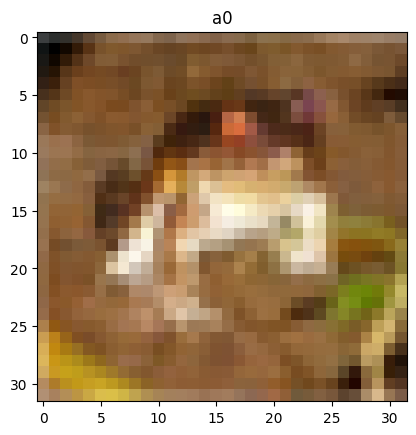

In [4]:
# Bullet 4, Figure out how to display some of the images in this data set, and display a couple. 
#   While not high resolution, these should be recognizable if you are doing it correctly.
# Lists the category labels for entries
descr = 'Category Labels \n'+ str(cifar['DESCR']).rsplit(sep=':', maxsplit=2)[2].split('The')[0].strip()
print(descr)

x, y, x_names, y_names = cifar['data'], cifar['target'], cifar['feature_names'], cifar['target_names']

x = np.array(x)

# Reshaping the images so they may be processsed 
# print(x.shape)
images = x.reshape(len(x), 3,32,32)
images = images.transpose(0,2,3,1)
# print(images.shape)

# Displaying a single image
plt.imshow(images[0]/255)
plt.title(x_names[0])


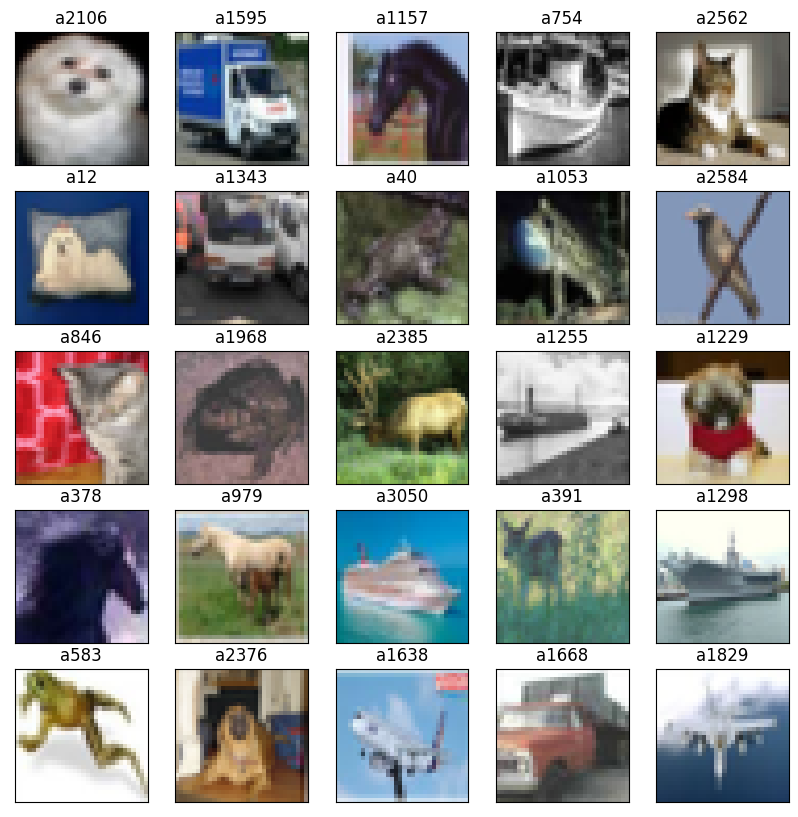

In [5]:
# Displaying multiple images at once
rows, columns = 5, 5
imageId = np.random.randint(0, len(images), rows * columns)
multiImages = images[imageId]
# print(len(x_names))
labels = [x_names[i%3072] for i in imageId]

fig = plt.figure(figsize=(10, 10))
for i in range(1, rows*columns+1,1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(multiImages[i-1]/255)
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(labels[i-1]))
plt.show()

In [6]:
# Bullet 5, There are 20,000 data points. Do a train-test split on 3/4 - 1/4.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, train_size=0.75)

In [7]:
# Bullet 6, Run multi-class logistic regression on these using the cross entropy loss.
# Bullet 7, Report your training and test loss.

# Creates constants 
penalties = ['l1', 'l2']
l1_acc, l1_scores = [], []
l2_acc, l2_scores = [], []

In [18]:
# L1 Penalty, Lasso Regression 

cv = 3
lr1 = LogisticRegressionCV(penalty=penalties[0], multi_class="multinomial", solver='saga', cv=cv, max_iter=500, tol=0.1)
lr1.fit(x_train, y_train)
y_predict = lr1.predict(x_test)
l1_acc.append(accuracy_score(y_test, y_predict))
l1_scores.append((lr1.score(x_train, y_train), lr1.score(x_test, y_test)))

print("At cross validation of {}, the accuracy is {:.2%}".format(cv, max(l1_acc)))
print("Training Score: {:.2%}; Test Score: {:.2%}".format(l1_scores[0][0], l1_scores[0][1]))

At cross validation of 3, the accuracy is 39.02%
Training Score: 45.37%; Test Score: 39.02%


In [19]:
# L2 Penalty, Ridge Regression

cv = 3
lr2 = LogisticRegressionCV(penalty=penalties[1], multi_class="multinomial", solver='saga', cv=cv, max_iter=500, tol=0.1)
lr2.fit(x_train, y_train)
y_predict = lr2.predict(x_test)
l2_acc.append(accuracy_score(y_test, y_predict))
l2_scores.append((lr2.score(x_train, y_train), lr2.score(x_test, y_test)))

print("At cross validation of {}, the accuracy is {:.2%}".format(cv, max(l2_acc)))
print("Training Score: {:.2%}; Test Score: {:.2%}".format(l2_scores[0][0], l2_scores[0][1]))

At cross validation of 3, the accuracy is 38.62%
Training Score: 44.12%; Test Score: 38.62%


In [23]:
# Bullet 8, How sparse can you make your solutions without deteriorating your testing error too much?


print('The number of features for our model:', lr1.coef_.shape[1])
# lr1.sparsify()

lr_sparse_acc = []
lr_sparse_scores = []
C_list = [10, 5, 1]

cv_sparse = 3
for c in C_list:
    print(c)
    lr_sparse = LogisticRegressionCV(Cs=c, penalty=penalties[0], multi_class="multinomial", solver='saga', cv=cv_sparse, max_iter=500, tol=0.1, n_jobs=6)
    lr_sparse.fit(x_train, y_train)
    y_predict = lr_sparse.predict(x_test)
    lr_sparse_acc.append(accuracy_score(y_test, y_predict))
    lr_sparse_scores.append((lr_sparse.score(x_train, y_train), lr_sparse.score(x_test, y_test)))

print("Float values of C")
lr_sparse = LogisticRegressionCV(Cs=[0.1, 0.001, 0.0001], penalty=penalties[0], multi_class="multinomial", solver='saga', cv=cv_sparse, max_iter=500, tol=0.1, n_jobs=6)
lr_sparse.fit(x_train, y_train)
y_predict = lr_sparse.predict(x_test)
lr_sparse_acc.append(accuracy_score(y_test, y_predict))
lr_sparse_scores.append((lr_sparse.score(x_train, y_train), lr_sparse.score(x_test, y_test)))


The number of features for our model: 3072
10
5
1
Float values of C


In [25]:
# Bullet 8 Final Values
print("At cross validation of {}, the accuracy is {:.2%}".format(cv, max(l1_acc))) # Modify this to find best score.
print("Training Score: {:.2%}; Test Score: {:.2%}".format(lr_sparse_scores[l1_acc.index(max(l1_acc))][0], lr_sparse_scores[l1_acc.index(max(l1_acc))][1]))

At cross validation of 3, the accuracy is 39.02%
Training Score: 45.02%; Test Score: 39.56%


# Problem 4: Revisiting Logistic Regression and CIFAR-10.
As before, we’ll throw the kitchen sink of classical ML (i.e. pre-deep learning) on CIFAR-10. Keep in mind that CIFAR-10 is a few times larger. <br>
• What is the best accuracy you can get on the test data, by tuning Random Forests? What are the hyperparameters of your best model? <br>
• What is the best accuracy you can get on the test data, by tuning any model including Gradient boosting? What are the hyperparameters of your best model?

In [ ]:
# Part 1, What is the best accuracy you can get on the test data, by tuning Random Forests? What are the hyperparameters of your best model?

acc_est = []
acc_depth = []
acc_gamma = []

est =   [10, 20, 100, 200, 300, 400, 500, 600]
depth = [None, 6, 10, 20, 50, 100, 250, 500]
gamma = [1, 2, 10, 20, 100, 200, 1000, 2000]

# Tunning Estimator
print("Tunning the n_est")
for e in est:
    print(e)
    rfc = RandomForestClassifier(n_estimators=e, criterion="gini", max_depth=None, ccp_alpha=0)
    rfc.fit(x_train, y_train)
    y_pred_rfc = rfc.predict(x_test)
    acc_est.append(accuracy_score(y_test, y_pred_rfc))

print("Tunning the depth")
# Tunning depth
for d in depth:
    print(d)
    rfc = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=e, ccp_alpha=0)
    rfc.fit(x_train, y_train)
    y_pred_rfc = rfc.predict(x_test)
    acc_depth.append(accuracy_score(y_test, y_pred_rfc))

print("Tunning the gamma")
# Tunning gamma
for g in gamma:
    print(g)
    rfc = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=None, ccp_alpha=g)
    rfc.fit(x_train, y_train)
    y_pred_rfr = rfc.predict(x_test)
    acc_gamma.append(accuracy_score(y_test, y_pred_rfr))

In [ ]:
print(max(acc_est), max(acc_depth), max(acc_gamma))

rfc = RandomForestClassifier(n_estimators=max(acc_est), criterion="gini", max_depth=max(acc_depth), ccp_alpha=max(acc_gamma))
rfc.fit(x_train, y_train)
y_pred_rfr = rfc.predict(x_test)
print("Maximized accuracy score: {:.2%}".format(accuracy_score(y_test, y_pred_rfr)))

In [ ]:
# Part 2, What is the best accuracy you can get on the test data, by tuning any model including Gradient boosting? What are the hyperparameters of your best model?
